In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
train_dir = 'Train'
test_dir = 'Test'

img_height = 384
img_width = 512
batch_size = 8
num_classes = len(os.listdir(train_dir))


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1  
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2020 images belonging to 9 classes.
Found 219 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


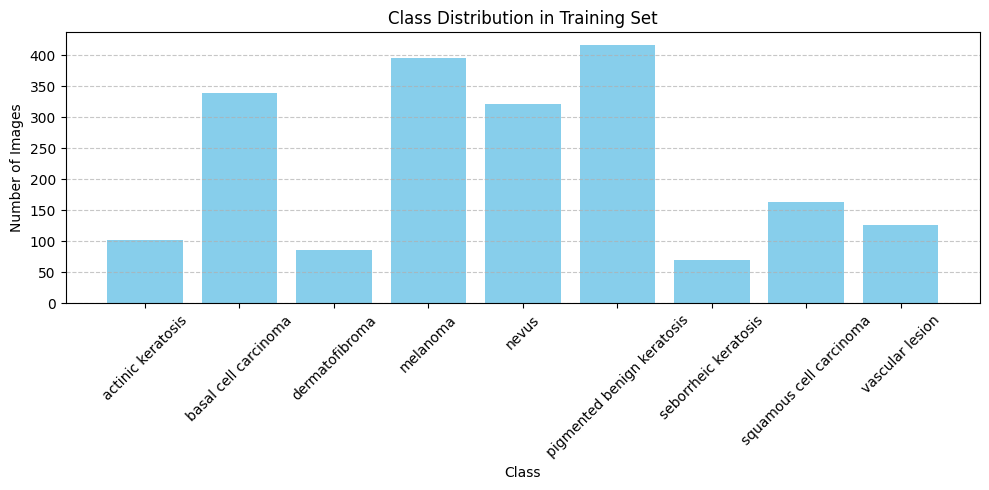

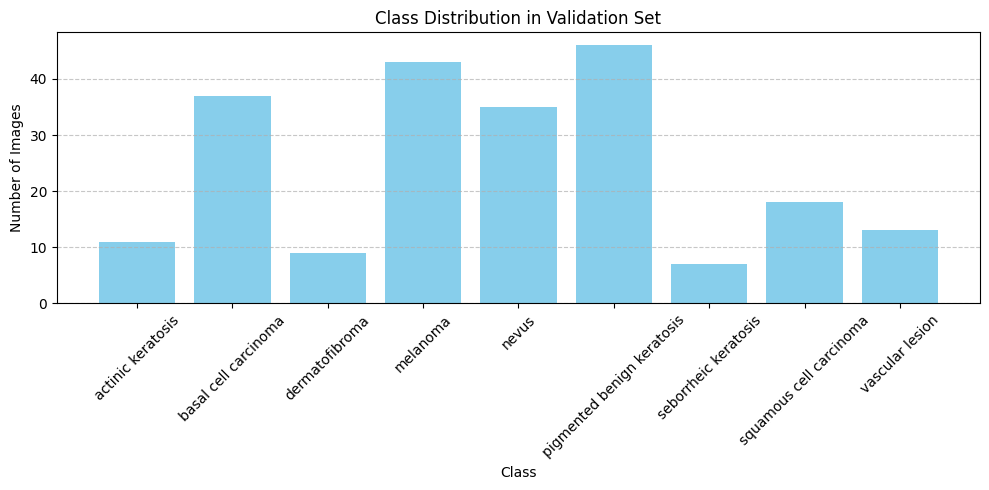

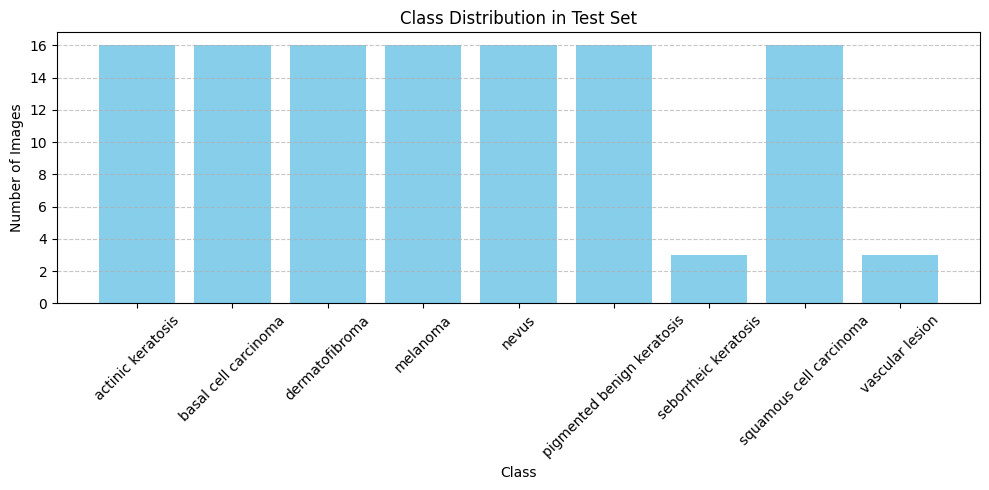

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot class distribution
def plot_class_distribution(data_gen, title):
    class_counts = np.bincount(data_gen.classes)
    class_labels = list(data_gen.class_indices.keys())

    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.title(f'Class Distribution in {title}')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot distributions
plot_class_distribution(train_data, "Training Set")
plot_class_distribution(val_data, "Validation Set")
plot_class_distribution(test_data, "Test Set")


In [5]:
import numpy as np

# Count number of images per class
class_counts = np.bincount(train_data.classes)
total_samples = np.sum(class_counts)
num_classes = len(class_counts)

# Compute weights: inversely proportional to class frequency
class_weights = {
    i: total_samples / (num_classes * count)
    for i, count in enumerate(class_counts)
}

# Print weights
print("Class Counts:", dict(enumerate(class_counts)))
print("Class Weights:", class_weights)


Class Counts: {0: 103, 1: 339, 2: 86, 3: 395, 4: 322, 5: 416, 6: 70, 7: 163, 8: 126}
Class Weights: {0: 2.179072276159655, 1: 0.6620780072107506, 2: 2.6098191214470283, 3: 0.5682137834036568, 4: 0.6970324361628709, 5: 0.5395299145299145, 6: 3.2063492063492065, 7: 1.3769597818677572, 8: 1.781305114638448}


In [6]:
import tensorflow as tf
from keras.applications import DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.layers import LeakyReLU

def build_improved_skin_cancer_model(input_shape=(384, 512, 3), num_classes=9):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    
    # Unfreeze last Dense block for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.5)(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the improved model
model = build_improved_skin_cancer_model(input_shape=(384, 512, 3), num_classes=9)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 390, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 192, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [7]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    class_weight=class_weights
)

Epoch 1/20
253/253 [==============================] - 357s 1s/step - loss: 2.1594 - accuracy: 0.2193 - val_loss: 1.5755 - val_accuracy: 0.4475
Epoch 2/20
253/253 [==============================] - 296s 1s/step - loss: 1.7018 - accuracy: 0.3564 - val_loss: 1.5990 - val_accuracy: 0.4795
Epoch 3/20
253/253 [==============================] - 310s 1s/step - loss: 1.5189 - accuracy: 0.4124 - val_loss: 1.4725 - val_accuracy: 0.5023
Epoch 4/20
253/253 [==============================] - 274s 1s/step - loss: 1.4331 - accuracy: 0.4371 - val_loss: 1.4345 - val_accuracy: 0.5662
Epoch 5/20
253/253 [==============================] - 272s 1s/step - loss: 1.3321 - accuracy: 0.4520 - val_loss: 1.2819 - val_accuracy: 0.5799
Epoch 6/20
253/253 [==============================] - 278s 1s/step - loss: 1.2669 - accuracy: 0.4743 - val_loss: 1.3926 - val_accuracy: 0.5936
Epoch 7/20
253/253 [==============================] - 278s 1s/step - loss: 1.2290 - accuracy: 0.5119 - val_loss: 1.3122 - val_accuracy: 0.5616

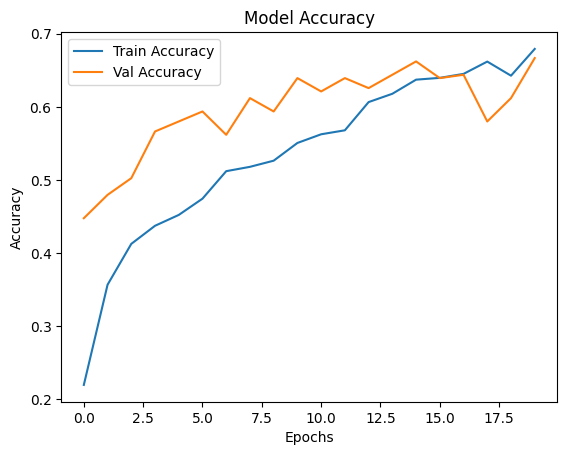

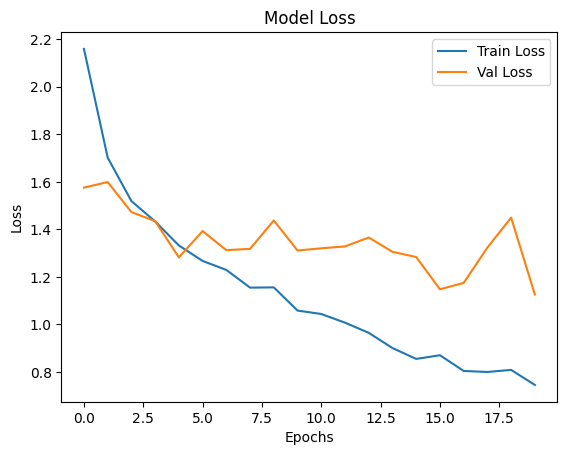

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


253/253 [==============================] - 122s 483ms/step


<Figure size 1000x800 with 0 Axes>

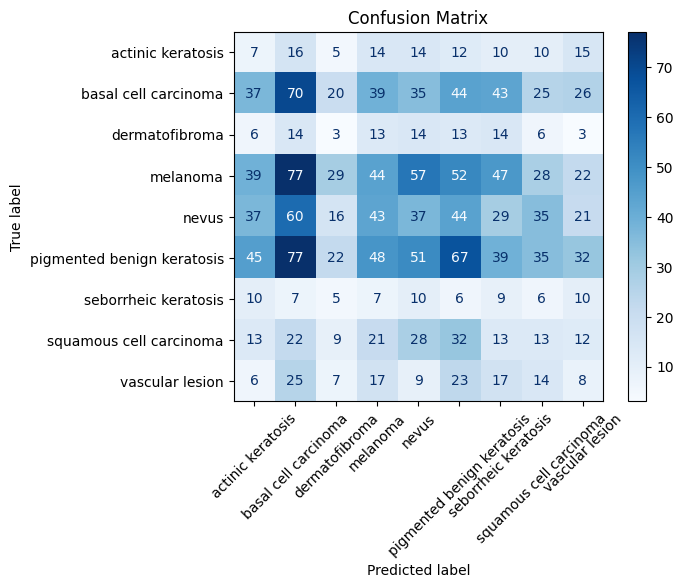

In [11]:
# Confusion Matrix of Train Data
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Getting predictions
y_pred_probs = model.predict(train_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = train_data.classes

# Getting class labels
class_labels = list(train_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plotting
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

15/15 [==============================] - 15s 674ms/step


<Figure size 1000x800 with 0 Axes>

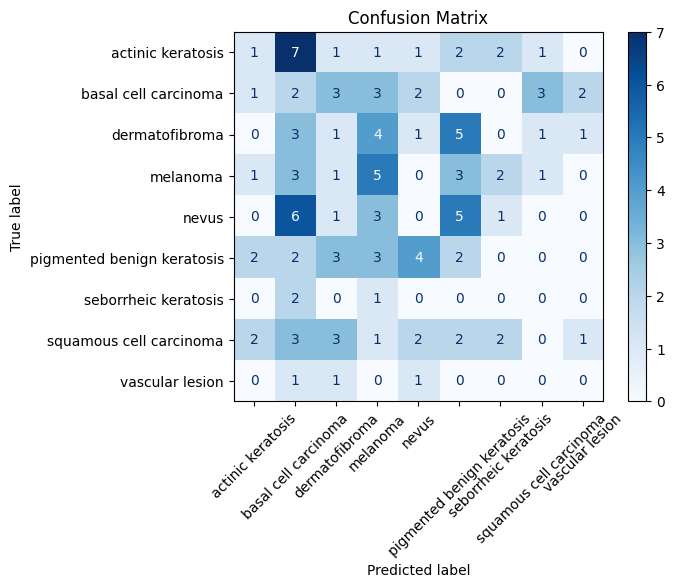

In [9]:
# Confusion Matrix of Test Data
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Getting predictions
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_data.classes

# Getting class labels
class_labels = list(test_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plotting
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [10]:
model.save('skin_cancer_cnn_model.h5')